# New Section

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=94fa7712b0ec48cd58e6ce68d4971b0a21c4c7a180e0b530d1487b195bd36289
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
nltk.download('stopwords')
from timeit import default_timer as timer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Blog authorship corpus/Blog_processed.csv')
# df.head()

In [ ]:
data = df['processed_text_string']

In [ ]:
def sent_to_words(sentences):
    count = 0
    for sentence in sentences:
        print(count, len(data))
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        count+=1

data_words = list(sent_to_words(data))

print(data_words[:1])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

import pickle
dwns = open("data_words_nostops.txt", "wb")
pickle.dump(data_words_nostops ,dwns)
dwns.close()

In [ ]:
from google.colab import files
files.download('data_words_nostops.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.phrases.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
print("bigram done")
trigram = gensim.models.phrases.Phrases(bigram[data_words], threshold=100)  
print("trigram done")

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
print("bigram_mod done")
trigram_mod = gensim.models.phrases.Phraser(trigram)
print("trigram_mod done")

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

bigram done


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


trigram done
bigram_mod done
trigram_mod done
['info', 'page', 'file', 'wait', 'until', 'team', 'leader', 'process', 'learn', 'html']


In [ ]:
!python -m spacy download en_core_web_md

import en_core_web_md
nlp = en_core_web_md.load()

     |████████████████████████████████| 96.4MB 60.0MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=b09651b71f59ee78b5d8bf9f68eeee52efc890875d64f30a4a6d180648e6c93a
  Stored in directory: /tmp/pip-ephem-wheel-cache-aztm6lad/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    count=0
    for sent in texts:
        print(count, len(texts))
        count+=1
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

import pickle
dwb = open("data_words_bigrams.txt", "wb")
pickle.dump(data_words_bigrams ,dwb)
dwb.close()

In [ ]:
from google.colab import files
files.download('data_words_bigrams.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
data_words_bigrams = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Blog authorship corpus/data_words_bigrams.txt', 'rb'))

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [ ]:
import pickle
id2w = open("id2word.txt", "wb")
pickle.dump(id2word ,id2w)
id2w.close()

data_lem = open("data_lemmatized.txt", "wb")
pickle.dump(data_lemmatized ,data_lem)
data_lem.close()

crpus = open("corpus.txt", "wb")
pickle.dump(corpus, crpus)
crpus.close()

In [ ]:
from google.colab import files
files.download('data_lemmatized.txt')

files.download('id2word.txt')

files.download('corpus.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
data_lemmatized = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Blog authorship corpus/data_lemmatized.txt', 'rb'))
id2word = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Blog authorship corpus/id2word.txt', 'rb'))
corpus = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Blog authorship corpus/corpus.txt', 'rb'))

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('file', 1),
  ('html', 1),
  ('info', 1),
  ('leader', 1),
  ('learn', 1),
  ('page', 1),
  ('process', 1),
  ('team', 1),
  ('wait', 1)]]

In [ ]:
!pip install numba

In [ ]:
# from numba import jit, cuda
import numpy as np
from numba import jit, njit, vectorize, cuda
# from timeit import default_timer as timer

In [ ]:
@vectorize(['int64(int64)'], target='cuda')
def func(a):
  for i in range(10000000):
    a[i]+=1

@jit
def func2(a):
  for i in range(10000000):
    a[i]+=1

if __name__ == "__main__":
  n=10000000
  a = np.ones(n, dtype=np.float64)
  b = np.ones(n, dtype=np.float32)

  start = timer()
  func(a)
  print("without gpu: ", timer()-start)
  start = timer()
  func2(a)
  print("with gpu: ", timer()-start)

## Function compute_coherence_values returns a list of model, coherence values and perplexity values for different values of number of topics.

In [ ]:
# from numba import jit, cuda 
# import numpy as np

# @jit
# # (target ="cuda")
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    perplexity_value = []
    for num_topics in range(start, limit, step):
        start = timer()
        print(num_topics, limit, step,end=' ')
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=1,
                                           passes=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_value.append(model.log_perplexity(corpus))
        print(timer()-start)
        print('------------')

    return model_list, coherence_values, perplexity_value

### Number of topics from range 44 - 80

In [ ]:
# Can take a long time to run.
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

2 40 6 430.057138486
------------
8 40 6 695.6193528270001
------------
14 40 6 870.9366201519997
------------
20 40 6 1084.9574699129998
------------
26 40 6 1267.991185105
------------
32 40 6 1499.3774375840003
------------
38 40 6 1887.1623107860005
------------


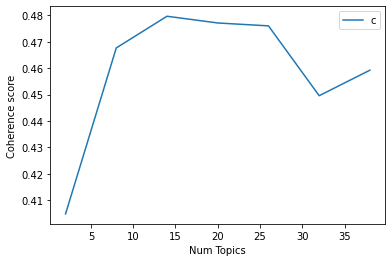

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4048
Num Topics = 8  has Coherence Value of 0.4676
Num Topics = 14  has Coherence Value of 0.4796
Num Topics = 20  has Coherence Value of 0.4771
Num Topics = 26  has Coherence Value of 0.476
Num Topics = 32  has Coherence Value of 0.4496
Num Topics = 38  has Coherence Value of 0.4592


In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))
# pprint(model_topics)

[(0,
  '0.051*"know" + 0.046*"think" + 0.036*"want" + 0.028*"thing" + 0.027*"go" + '
  '0.025*"feel" + 0.018*"tell" + 0.018*"time" + 0.018*"say" + 0.017*"friend"'),
 (1,
  '0.104*"play" + 0.065*"game" + 0.037*"team" + 0.025*"good" + 0.018*"lose" + '
  '0.017*"player" + 0.014*"beat" + 0.012*"season" + 0.012*"time" + '
  '0.012*"ball"'),
 (2,
  '0.024*"think" + 0.018*"peopl" + 0.015*"person" + 0.014*"time" + '
  '0.013*"live" + 0.012*"know" + 0.011*"thing" + 0.011*"differ" + 0.010*"good" '
  '+ 0.009*"mean"'),
 (3,
  '0.035*"work" + 0.020*"money" + 0.016*"need" + 0.012*"sell" + 0.010*"pay" + '
  '0.010*"program" + 0.009*"price" + 0.009*"develop" + 0.009*"product" + '
  '0.009*"month"'),
 (4,
  '0.073*"love" + 0.042*"feel" + 0.024*"heart" + 0.023*"know" + 0.020*"life" + '
  '0.018*"dream" + 0.015*"time" + 0.014*"away" + 0.013*"come" + 0.012*"live"'),
 (5,
  '0.061*"test" + 0.047*"bring" + 0.032*"doctor" + 0.029*"urllink" + '
  '0.026*"result" + 0.022*"partner" + 0.020*"level" + 0.016*"hig

### Number of topics from range 44 - 80

In [ ]:
# Can take a long time to run.
model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=44, limit=80, step=6)

44 80 6 1978.8353855500009
------------
50 80 6 2126.761853872
------------
56 80 6 2386.7235957639987
------------
62 80 6 2576.751829042998
------------
68 80 6 2772.7152031290025
------------
74 80 6 3548.333592723997
------------


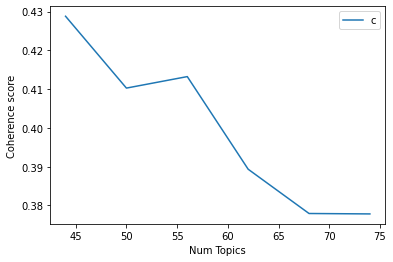

In [ ]:
# Show graph
limit=80; start=44; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 44  has Coherence Value of 0.4288
Num Topics = 50  has Coherence Value of 0.4103
Num Topics = 56  has Coherence Value of 0.4132
Num Topics = 62  has Coherence Value of 0.3894
Num Topics = 68  has Coherence Value of 0.3779
Num Topics = 74  has Coherence Value of 0.3778


In [ ]:
# Select the model and print the topics
optimal_model = model_list2[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))
pprint(model_topics)

[(26,
  '0.145*"say" + 0.075*"tell" + 0.053*"ask" + 0.049*"know" + 0.031*"think" + '
  '0.026*"question" + 0.024*"come" + 0.023*"answer" + 0.021*"want" + '
  '0.021*"talk"'),
 (32,
  '0.049*"kill" + 0.035*"fight" + 0.030*"attack" + 0.024*"report" + '
  '0.019*"nation" + 0.016*"american" + 0.015*"soldier" + 0.015*"say" + '
  '0.013*"murder" + 0.012*"terror"'),
 (42,
  '0.174*"wear" + 0.080*"black" + 0.072*"dress" + 0.059*"shoe" + 0.058*"cloth" '
  '+ 0.055*"shirt" + 0.036*"pant" + 0.020*"short" + 0.019*"steal" + '
  '0.016*"look"'),
 (9,
  '0.071*"go" + 0.048*"home" + 0.041*"come" + 0.024*"time" + 0.024*"take" + '
  '0.022*"call" + 0.021*"want" + 0.021*"wait" + 0.018*"hour" + 0.015*"phone"'),
 (21,
  '0.676*"love" + 0.096*"dream" + 0.026*"true" + 0.019*"heart" + '
  '0.015*"passion" + 0.014*"fall" + 0.010*"angel" + 0.006*"pirat" + '
  '0.006*"chew" + 0.005*"hyper"'),
 (34,
  '0.147*"school" + 0.111*"class" + 0.083*"test" + 0.058*"teacher" + '
  '0.037*"year" + 0.033*"high" + 0.029*"grad

In [ ]:
final_model_list=model_list+model_list2
print(final_model_list)

[<gensim.models.ldamodel.LdaModel object at 0x7fc9cc8a59e8>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cc798be0>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cbc82e48>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cbd50d68>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cc6e0e48>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cc6e0320>, <gensim.models.ldamodel.LdaModel object at 0x7fc9c543aeb8>, <gensim.models.ldamodel.LdaModel object at 0x7fc9ca5e0e80>, <gensim.models.ldamodel.LdaModel object at 0x7fc9c7541f28>, <gensim.models.ldamodel.LdaModel object at 0x7fc9c69d5f28>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cc6e0828>, <gensim.models.ldamodel.LdaModel object at 0x7fc9cbc82dd8>, <gensim.models.ldamodel.LdaModel object at 0x7fc9c2ba0fd0>]


In [ ]:
print(coherence_values+coherence_values2)
final_coherence_value = coherence_values+coherence_values2
print(final_coherence_value)

[0.4048223019407592, 0.4676388252010352, 0.4796279020723006, 0.4770809870073456, 0.4759895900112251, 0.4495640451714338, 0.4592129140352393, 0.42881682586055375, 0.4102821117313581, 0.41324611289867125, 0.38935282883286887, 0.37792997240752146, 0.3778223605315474]
[0.4048223019407592, 0.4676388252010352, 0.4796279020723006, 0.4770809870073456, 0.4759895900112251, 0.4495640451714338, 0.4592129140352393, 0.42881682586055375, 0.4102821117313581, 0.41324611289867125, 0.38935282883286887, 0.37792997240752146, 0.3778223605315474]


In [ ]:
len(final_coherence_value)

2

Graph of coherence score vs no of topics (2-80)

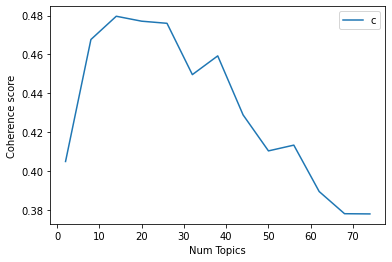

In [ ]:
# Show graph
limit=80; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, final_coherence_value)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
import pickle
Model = open('model.pkl', 'wb')
pickle.dump(model_list[2], Model)
Model.close()

In [ ]:
file = pickle.load(open('/content/model.pkl', 'rb'))

In [ ]:
file.log_perplexity(corpus)

-7.0532009114097525

In [ ]:
pprint(file.print_topics())


[(0,
  '0.051*"know" + 0.046*"think" + 0.036*"want" + 0.028*"thing" + 0.027*"go" + '
  '0.025*"feel" + 0.018*"tell" + 0.018*"time" + 0.018*"say" + 0.017*"friend"'),
 (1,
  '0.104*"play" + 0.065*"game" + 0.037*"team" + 0.025*"good" + 0.018*"lose" + '
  '0.017*"player" + 0.014*"beat" + 0.012*"season" + 0.012*"time" + '
  '0.012*"ball"'),
 (2,
  '0.024*"think" + 0.018*"peopl" + 0.015*"person" + 0.014*"time" + '
  '0.013*"live" + 0.012*"know" + 0.011*"thing" + 0.011*"differ" + 0.010*"good" '
  '+ 0.009*"mean"'),
 (3,
  '0.035*"work" + 0.020*"money" + 0.016*"need" + 0.012*"sell" + 0.010*"pay" + '
  '0.010*"program" + 0.009*"price" + 0.009*"develop" + 0.009*"product" + '
  '0.009*"month"'),
 (4,
  '0.073*"love" + 0.042*"feel" + 0.024*"heart" + 0.023*"know" + 0.020*"life" + '
  '0.018*"dream" + 0.015*"time" + 0.014*"away" + 0.013*"come" + 0.012*"live"'),
 (5,
  '0.061*"test" + 0.047*"bring" + 0.032*"doctor" + 0.029*"urllink" + '
  '0.026*"result" + 0.022*"partner" + 0.020*"level" + 0.016*"hig

### Since no of topics between 10-30 gave max values, so now the range is from step 10-25

In [ ]:
# Can take a long time to run.
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=25, step=2)

10 25 2 1049.3046857380004
------------
12 25 2 1104.515523785
------------
14 25 2 1152.6483310570002
------------
16 25 2 1247.7988217539996
------------
18 25 2 1286.7527787950003
------------
20 25 2 1380.2429301009997
------------
22 25 2 1469.5290815070002
------------
24 25 2 1524.9638044849999
------------


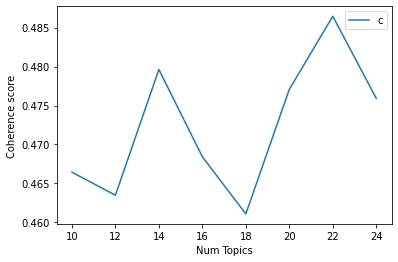

In [ ]:
# Show graph
limit=25; start=10; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4664
Num Topics = 12  has Coherence Value of 0.4635
Num Topics = 14  has Coherence Value of 0.4796
Num Topics = 16  has Coherence Value of 0.4684
Num Topics = 18  has Coherence Value of 0.4611
Num Topics = 20  has Coherence Value of 0.4771
Num Topics = 22  has Coherence Value of 0.4865
Num Topics = 24  has Coherence Value of 0.4759


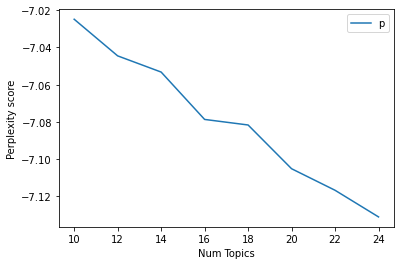

In [ ]:
# Show graph
limit=25; start=10; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Print the perplexity scores
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))

Num Topics = 10  has Perplexity Value of -7.0248
Num Topics = 12  has Perplexity Value of -7.0445
Num Topics = 14  has Perplexity Value of -7.0532
Num Topics = 16  has Perplexity Value of -7.0786
Num Topics = 18  has Perplexity Value of -7.0816
Num Topics = 20  has Perplexity Value of -7.1051
Num Topics = 22  has Perplexity Value of -7.1167
Num Topics = 24  has Perplexity Value of -7.131


### Best model i.e with no of topics = 22

In [ ]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))
pprint(model_topics)

[(0,
  '0.062*"go" + 0.045*"today" + 0.032*"think" + 0.028*"know" + 0.020*"talk" + '
  '0.017*"good" + 0.017*"want" + 0.017*"come" + 0.017*"thing" + 0.017*"feel"'),
 (20,
  '0.016*"question" + 0.015*"differ" + 0.014*"person" + 0.011*"creat" + '
  '0.011*"mean" + 0.011*"understand" + 0.010*"human" + 0.010*"peopl" + '
  '0.009*"answer" + 0.009*"think"'),
 (19,
  '0.096*"play" + 0.054*"game" + 0.044*"watch" + 0.040*"good" + 0.031*"team" + '
  '0.031*"movi" + 0.018*"time" + 0.013*"see" + 0.013*"lose" + 0.012*"player"'),
 (13,
  '0.077*"wear" + 0.058*"look" + 0.044*"drink" + 0.029*"dress" + 0.026*"shoe" '
  '+ 0.024*"shirt" + 0.024*"cloth" + 0.019*"woman" + 0.015*"pant" + '
  '0.013*"french"'),
 (17,
  '0.129*"write" + 0.126*"read" + 0.070*"book" + 0.026*"word" + 0.018*"think" '
  '+ 0.018*"page" + 0.015*"paper" + 0.015*"interest" + 0.014*"letter" + '
  '0.012*"blog"'),
 (8,
  '0.101*"say" + 0.029*"woman" + 0.025*"tell" + 0.019*"ask" + 0.019*"kill" + '
  '0.016*"vote" + 0.013*"call" + 0.013

In [ ]:
import pickle
Model = open('model.pkl', 'wb')
pickle.dump(model_list[6], Model)
Model.close()

In [ ]:
import pickle
model = pickle.load(open('//content//drive//My Drive//Colab Notebooks//Blog authorship corpus//model.pkl', 'rb'))

### Function compute_coherence_values would return list of models, coherence score and perplexity value by varying the no of passes.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    perplexity_value = []
    for passes in range(start, limit, step):
        start = timer()
        print(passes, limit, step,end=' ')
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=1,
                                           passes=passes)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_value.append(model.log_perplexity(corpus))
        print(timer()-start)
        print('------------')

    return model_list, coherence_values, perplexity_value

### The following line prints
no of passes, max passes, diff b/w passes and seconds it took to compute.
### No of Passes from 1-5 on the best model i.e with 22 no of topics

In [ ]:
# Can take a long time to run.
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=6, step=1)

1 6 1 1554.0581276220003
------------
2 6 1 1969.0414118040003
------------
3 6 1 2343.765638445
------------
4 6 1 2685.377140058001
------------
5 6 1 2935.539214957
------------


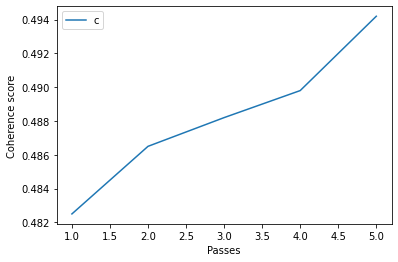

In [ ]:
# Show graph
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Passes")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

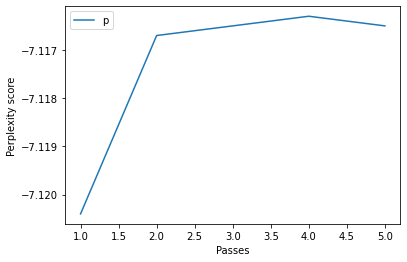

In [ ]:
# Show graph
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Passes")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Print the perplexity scores
p=[1,2,3,4,5]
for m, cv in zip(p, perplexity_values):
    print("Num Passes =", m, " has Perplexity Value of", round(cv, 4))

Num Passes = 1  has Perplexity Value of -7.1204
Num Passes = 2  has Perplexity Value of -7.1167
Num Passes = 3  has Perplexity Value of -7.1165
Num Passes = 4  has Perplexity Value of -7.1163
Num Passes = 5  has Perplexity Value of -7.1165


In [ ]:
# Print the coherence scores
p=[1,2,3,4,5]
for m, cv in zip(p, coherence_values):
    print("Num Passes =", m, " has Coherence Score of", round(cv, 4))

Num Passes = 1  has Coherence Score of 0.4825
Num Passes = 2  has Coherence Score of 0.4865
Num Passes = 3  has Coherence Score of 0.4882
Num Passes = 4  has Coherence Score of 0.4898
Num Passes = 5  has Coherence Score of 0.4942




1.   model with 22 no of topics and __2__ passes gave __0.4865 coherence value__.
Increasing the no of passes to __5__ gave __0.4942__ coherence value.
2.   No significant change was observed in perplexity score.



### No of Passes from 6-10 on the best model i.e with 22 no of topics

In [ ]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=6, limit=11, step=1)

6 11 1 2651.487138977
------------
7 11 1 2940.4907407319997
------------
8 11 1 3221.3595890669994
------------
9 11 1 3532.8401550180006
------------
10 11 1 3842.5153331460006
------------


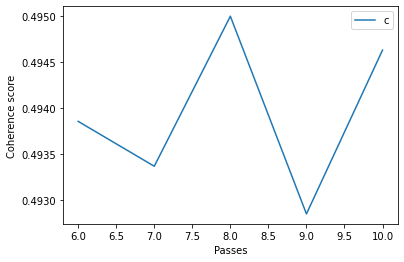

In [ ]:
# Show graph
limit=11; start=6; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Passes")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

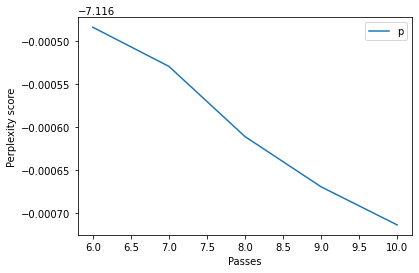

In [ ]:
# Show graph
limit=11; start=6; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Passes")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Print the perplexity scores
p=[6,7,8,9,10]
for m, cv in zip(p, perplexity_values):
    print("Num Passes =", m, " has Perplexity Value of", round(cv, 4))

Num Passes = 6  has Perplexity Value of -7.1165
Num Passes = 7  has Perplexity Value of -7.1165
Num Passes = 8  has Perplexity Value of -7.1166
Num Passes = 9  has Perplexity Value of -7.1167
Num Passes = 10  has Perplexity Value of -7.1167


In [ ]:
# Print the coherence scores
c=[6,7,8,9,10]
for m, cv in zip(c, coherence_values):
    print("Num Passes =", m, " has Coherence Score of", round(cv, 4))

Num Passes = 6  has Coherence Score of 0.4939
Num Passes = 7  has Coherence Score of 0.4934
Num Passes = 8  has Coherence Score of 0.495
Num Passes = 9  has Coherence Score of 0.4928
Num Passes = 10  has Coherence Score of 0.4946


### Combined visualizations from no of passes 1-10

In [ ]:
total_coherence_values = [0.4825, 0.4865, 0.4882, 0.4898, 0.4942, 0.4939, 0.4934, 0.495, 0.4928, 0.4946]
total_perplexity_values = [-7.1204, -7.1167, -7.1165, -7.1163, -7.1165, -7.1165, -7.1165, -7.1166, -7.1167, -7.1167]
passes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

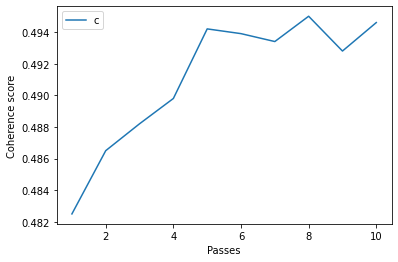

In [ ]:
# Show graph
limit=11; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, total_coherence_values)
plt.xlabel("Passes")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

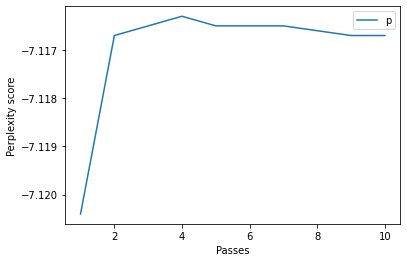

In [ ]:
# Show graph
limit=11; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, total_perplexity_values)
plt.xlabel("Passes")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Print the perplexity scores
for m, cv in zip(passes, total_perplexity_values):
    print("Num Passes =", m, " has Perplexity Value of", round(cv, 4))

Num Passes = 1  has Perplexity Value of -7.1204
Num Passes = 2  has Perplexity Value of -7.1167
Num Passes = 3  has Perplexity Value of -7.1165
Num Passes = 4  has Perplexity Value of -7.1163
Num Passes = 5  has Perplexity Value of -7.1165
Num Passes = 6  has Perplexity Value of -7.1165
Num Passes = 7  has Perplexity Value of -7.1165
Num Passes = 8  has Perplexity Value of -7.1166
Num Passes = 9  has Perplexity Value of -7.1167
Num Passes = 10  has Perplexity Value of -7.1167


In [ ]:
# Print the coherence scores
for m, cv in zip(passes, total_coherence_values):
    print("Num Passes =", m, " has Coherence Score of", round(cv, 4))

Num Passes = 1  has Coherence Score of 0.4825
Num Passes = 2  has Coherence Score of 0.4865
Num Passes = 3  has Coherence Score of 0.4882
Num Passes = 4  has Coherence Score of 0.4898
Num Passes = 5  has Coherence Score of 0.4942
Num Passes = 6  has Coherence Score of 0.4939
Num Passes = 7  has Coherence Score of 0.4934
Num Passes = 8  has Coherence Score of 0.495
Num Passes = 9  has Coherence Score of 0.4928
Num Passes = 10  has Coherence Score of 0.4946


Storing model with passes = 8

In [ ]:
import pickle
Model = open('model_T22_P8.pkl', 'wb')
pickle.dump(model_list[2], Model)
Model.close()

### No of Passes from 11-12 on the best model i.e with 22 no of topics

In [ ]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=11, limit=13, step=1)

11 13 1 5958.0937481149995
------------
12 13 1 6298.012905743
------------


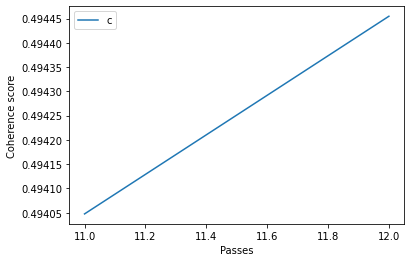

In [ ]:
# Show graph
limit=13; start=11; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Passes")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

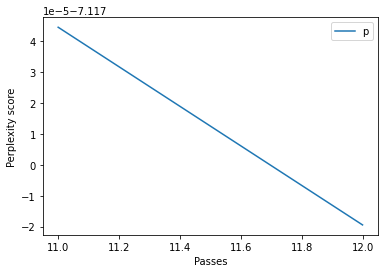

In [ ]:
# Show graph
limit=13; start=11; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Passes")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Print the perplexity scores
p=[11, 12]
for m, cv in zip(p, perplexity_values):
    print("Num Passes =", m, " has Perplexity Value of", round(cv, 4))

Num Passes = 11  has Perplexity Value of -7.117
Num Passes = 12  has Perplexity Value of -7.117


In [ ]:
# Print the coherence scores
c = [11, 12]
for m, cv in zip(c, coherence_values):
    print("Num Passes =", m, " has Coherence Score of", round(cv, 4))

Num Passes = 11  has Coherence Score of 0.494
Num Passes = 12  has Coherence Score of 0.4945


Conclusion: no of passes 8 gave best results i.e coherence of 0.495

# Regression Analysis
## y = ax<sup>b</sup>

## No of Topics = 22

In [ ]:
y = [0.4048223019407592, 0.4676388252010352, 0.4796279020723006, 0.4770809870073456, 0.4759895900112251, 0.4495640451714338, 0.4592129140352393, 0.42881682586055375, 0.4102821117313581, 0.41324611289867125, 0.38935282883286887, 0.37792997240752146, 0.3778223605315474]
x = [2,8,14,20,26,32,38,44,50,56,62,68,74]

In [ ]:
import numpy as np

In [ ]:
Y = np.array(y)
X = np.array(x)

In [ ]:
print(Y)

[0.4048223  0.46763883 0.4796279  0.47708099 0.47598959 0.44956405
 0.45921291 0.42881683 0.41028211 0.41324611 0.38935283 0.37792997
 0.37782236]


In [ ]:
a=[1,2,3,4,5]
b=[5,4,3,2,1]
m=np.array(a)
n=np.array(b)

In [ ]:
z = np.log(Y)
w = np.log(X)

In [ ]:
val1 = 13*np.sum(z*w)

In [ ]:
val2 = -1*np.sum(z)*np.sum(w)

In [ ]:
val3 = 13*np.sum(np.square(w))

In [ ]:
val4 = -1*np.square(np.sum(w))

In [ ]:
a1 = (val1 + val2)/(val3 + val4)
a1

-0.032728779481990905

In [ ]:
a0 = np.mean(z) - a1*np.mean(w)

In [ ]:
a = np.exp(a0)
b = a1

The equation y = ax<sup>b</sup> gives the values from 1.001-0.888 which is not close to real coherence values for no of topics 2-80

In [ ]:
for i in range(2,80,6):
  print(np.power(a*i,b), i)

1.001379043035236 2
0.9569600538503981 8
0.939592347051057 14
0.9286877537612365 20
0.9207473802700071 26
0.9145113940966838 32
0.9093822091931468 38
0.9050293057188233 44
0.9012507267319225 50
0.8979140808719347 56
0.8949279050837623 62
0.8922263857174129 68
0.8897605983469568 74


In [ ]:
# np.log(Y*X)
print(np.log(m*n))
print(np.log(m))
print(np.log(n))

[1.60943791 2.07944154 2.19722458 2.07944154 1.60943791]
[0.         0.69314718 1.09861229 1.38629436 1.60943791]
[1.60943791 1.38629436 1.09861229 0.69314718 0.        ]


In [ ]:
tuple(zip(x, y))

((2, 0.4048223019407592),
 (8, 0.4676388252010352),
 (14, 0.4796279020723006),
 (20, 0.4770809870073456),
 (26, 0.4759895900112251),
 (32, 0.4495640451714338),
 (38, 0.4592129140352393),
 (44, 0.42881682586055375),
 (50, 0.4102821117313581),
 (56, 0.41324611289867125),
 (62, 0.38935282883286887),
 (68, 0.37792997240752146),
 (74, 0.3778223605315474))

The final mathematical equation formed between coherence value and no of topics.

In [ ]:
# y = coherence
# x = no of topics
y = 0.01729658174701116 log(x) + 0.4676388252010352

[Wolfram](https://www.wolframalpha.com/input/?i=fit+%5B%282%2C+0.4048223019407592%29%2C++%288%2C+0.4676388252010352%29%2C++%2814%2C+0.4796279020723006%29%2C++%2820%2C+0.4770809870073456%29%2C++%2826%2C+0.4759895900112251%29%2C++%2832%2C+0.4495640451714338%29%2C++%2838%2C+0.4592129140352393%29%2C++%2844%2C+0.42881682586055375%29%2C++%2850%2C+0.4102821117313581%29%2C++%2856%2C+0.41324611289867125%29%2C++%2862%2C+0.38935282883286887%29%2C++%2868%2C+0.37792997240752146%29%2C++%2874%2C+0.3778223605315474%29%5D)

## No of passes = 1-10

In [ ]:
total_coherence_values = [0.4825, 0.4865, 0.4882, 0.4898, 0.4942, 0.4939, 0.4934, 0.495, 0.4928, 0.4946, 0.494, 0.4945]
total_perplexity_values = [-7.1204, -7.1167, -7.1165, -7.1163, -7.1165, -7.1165, -7.1165, -7.1166, -7.1167, -7.1167, -7.117]
passes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
import numpy as np
Y = np.array(total_coherence_values)
X = np.array(passes)

In [ ]:
z = np.log(Y)
w = np.log(X)

In [ ]:
l = len(passes)
l

12

In [ ]:
val1 = l*np.sum(z*w)

val2 = -1*np.sum(z)*np.sum(w)

val3 = l*np.sum(np.square(w))

val4 = -1*np.square(np.sum(w))

In [ ]:
a1 = (val1 + val2)/(val3 + val4)

a0 = np.mean(z) - a1*np.mean(w)

In [ ]:
a = np.exp(a0)
b = a1

In [ ]:
for i in range(1,13):
  print(np.power(a*i,b), i)

0.9926289682965652 1
0.9996552103541071 2
1.0037883315501843 3
1.0067311870849538 4
1.0090197833893488 5
1.0108935642375914 6
1.0124805378411275 7
1.0138572505318773 8
1.0150731509331365 9
1.0161620464759364 10
1.0171480785426759 11
1.0180490907269437 12


In [ ]:
tuple(zip(passes, total_coherence_values))

((1, 0.4825),
 (2, 0.4865),
 (3, 0.4882),
 (4, 0.4898),
 (5, 0.4942),
 (6, 0.4939),
 (7, 0.4934),
 (8, 0.495),
 (9, 0.4928),
 (10, 0.4946),
 (11, 0.494),
 (12, 0.4945))

In [ ]:
# logarithmic
import math
y = 0.00245258*np.log(passes) + 0.4865

In [ ]:
print(passes)
print(y)
print(total_coherence_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.4865     0.4882     0.48919443 0.4899     0.49044728 0.49089443
 0.4912725  0.4916     0.49188887 0.49214727 0.49238103 0.49259443]
[0.4825, 0.4865, 0.4882, 0.4898, 0.4942, 0.4939, 0.4934, 0.495, 0.4928, 0.4946, 0.494, 0.4945]


In [ ]:
mse = np.sum(np.square(np.subtract(y, Y)))/l

In [ ]:
print("mean square error = ", mse)

mean square error =  6.015818515753374e-06


[Wolfram](https://www.wolframalpha.com/input/?i=fit+%5B%281%2C+0.4825%29%2C++%282%2C+0.4865%29%2C++%283%2C+0.4882%29%2C++%284%2C+0.4898%29%2C++%285%2C+0.4942%29%2C++%286%2C+0.4939%29%2C++%287%2C+0.4934%29%2C++%288%2C+0.495%29%2C++%289%2C+0.4928%29%2C++%2810%2C+0.4946%29%2C++%2811%2C+0.494%29%2C++%2812%2C+0.4945%29%5D)